# Description

This notebook reads all gene correlations across all tissues and computes a single correlation matrix.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd

# from tqdm import tqdm

import conf
from entity import Gene

# Settings

In [3]:
# mashr
EQTL_MODEL = "MASHR"
EQTL_MODEL_FILES_PREFIX = "mashr_"

# # elastic net
# EQTL_MODEL = "ELASTIC_NET"
# EQTL_MODEL_FILES_PREFIX = "en_"

EQTL_MODEL_FILES_PREFIX = None

In [4]:
# Parameters
EQTL_MODEL = "ELASTIC_NET"


In [5]:
if EQTL_MODEL_FILES_PREFIX is None:
    EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS_PREFIXES"][EQTL_MODEL]

In [6]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

'Using eQTL model: ELASTIC_NET / en_'

In [7]:
INPUT_DIR = (
    conf.PHENOMEXCAN["LD_BLOCKS"]["BASE_DIR"] / f"{EQTL_MODEL_FILES_PREFIX}gene_corrs"
)
display(INPUT_DIR)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_gene_corrs')

# Load data

## Gene correlations

In [8]:
all_gene_corr_files = list(INPUT_DIR.rglob("*.pkl"))

In [9]:
len(all_gene_corr_files)

1078

In [10]:
all_gene_corr_files[:5]

[PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr21.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr4.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr18.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr10.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_gene_corrs/Adrenal_Gland/gene_corrs-Adrenal_Gland-chr13.pkl')]

In [11]:
assert len(all_gene_corr_files) == 22 * 49

In [12]:
all_gene_corr_files_df = pd.DataFrame({"corr_file": [f for f in all_gene_corr_files]})

In [13]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    file_name=all_gene_corr_files_df["corr_file"].apply(lambda x: x.name)
)

In [14]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    tissue=all_gene_corr_files_df["file_name"].apply(
        lambda x: x.split("-chr")[0].split("gene_corrs-")[1]
    )
)

In [15]:
all_gene_corr_files_df = all_gene_corr_files_df.assign(
    chromosome=all_gene_corr_files_df["file_name"].apply(
        lambda x: int(x.split("-chr")[1].split(".")[0])
    )
)

In [16]:
assert all_gene_corr_files_df["tissue"].unique().shape[0] == 49

In [17]:
assert all_gene_corr_files_df["chromosome"].unique().shape[0] == 22
assert set(all_gene_corr_files_df["chromosome"]) == set(range(1, 23))

In [18]:
all_gene_corr_files_df.shape

(1078, 4)

In [19]:
all_gene_corr_files_df.head()

,corr_file,file_name,tissue,chromosome
0,/opt/data/data/phenomexcan/ld_blocks/en_gene_c...,gene_corrs-Adrenal_Gland-chr21.pkl,Adrenal_Gland,21
1,/opt/data/data/phenomexcan/ld_blocks/en_gene_c...,gene_corrs-Adrenal_Gland-chr4.pkl,Adrenal_Gland,4
2,/opt/data/data/phenomexcan/ld_blocks/en_gene_c...,gene_corrs-Adrenal_Gland-chr18.pkl,Adrenal_Gland,18
3,/opt/data/data/phenomexcan/ld_blocks/en_gene_c...,gene_corrs-Adrenal_Gland-chr10.pkl,Adrenal_Gland,10
4,/opt/data/data/phenomexcan/ld_blocks/en_gene_c...,gene_corrs-Adrenal_Gland-chr13.pkl,Adrenal_Gland,13


## MultiPLIER Z

In [20]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [21]:
len(multiplier_z_genes)

6750

In [22]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [23]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [24]:
len(multiplier_gene_obj)

6454

In [25]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [26]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
    }
).dropna()

In [27]:
genes_info.shape

(6452, 3)

In [28]:
genes_info.head()

,name,id,chr
0,GAS6,ENSG00000183087,13
1,MMP14,ENSG00000157227,14
2,DSP,ENSG00000096696,6
3,MARCKSL1,ENSG00000175130,1
4,SPARC,ENSG00000113140,5


## Get tissues names

In [29]:
db_files = list(conf.PHENOMEXCAN["PREDICTION_MODELS"][EQTL_MODEL].glob("*.db"))

In [30]:
assert len(db_files) == 49

In [31]:
tissues = [str(f).split(EQTL_MODEL_FILES_PREFIX)[1].split(".db")[0] for f in db_files]

In [32]:
tissues[:5]

['Vagina',
 'Colon_Sigmoid',
 'Brain_Caudate_basal_ganglia',
 'Stomach',
 'Skin_Not_Sun_Exposed_Suprapubic']

# Average correlations per chromosome

In [33]:
corrs_per_chr = {}

for chr_num in range(1, 23):
    print(f"Chromosome: {chr_num}", flush=True)

    chr_files = all_gene_corr_files_df[all_gene_corr_files_df["chromosome"] == chr_num]
    print(f"Number of corrs files: {chr_files.shape}")

    multiplier_genes_in_chr = genes_info[genes_info["chr"] == str(chr_num)]
    print(f"Number of MultiPLIER genes: {multiplier_genes_in_chr.shape}")

    # create final dataframe with corrs for this chr
    chr_df = pd.DataFrame(
        data=0.0,
        index=multiplier_genes_in_chr["id"],
        columns=multiplier_genes_in_chr["id"],
    )

    print("Reading corrs per tissue", flush=True)
    for idx, tissue_corrs in chr_files.iterrows():
        tissue_corrs_df = pd.read_pickle(tissue_corrs["corr_file"])

        nan_values = tissue_corrs_df.isna()
        if nan_values.any().any():
            print(
                f"  WARNING ({tissue_corrs['tissue']}): has NaN values ({nan_values.sum().sum()})"
            )
            tissue_corrs_df = tissue_corrs_df.fillna(0.0)

        # align
        tissue_corrs_df = tissue_corrs_df.loc[chr_df.index, chr_df.columns]

        chr_df = chr_df + tissue_corrs_df
    #         chr_df = chr_df.where(chr_df.abs() > tissue_corrs_df.abs(), tissue_corrs_df).fillna(chr_df)

    chr_df = chr_df / float(chr_files.shape[0])
    chr_df_flat = pd.Series(squareform(chr_df.values, checks=False))
    display(chr_df_flat.describe())

    corrs_per_chr[chr_num] = chr_df

    print("\n")

Chromosome: 1
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (700, 3)
Reading corrs per tissue


count    244650.000000
mean          0.000036
std           0.005179
min          -0.657505
25%          -0.000830
50%           0.000000
75%           0.000844
max           0.449801
dtype: float64



Chromosome: 2
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (445, 3)
Reading corrs per tissue


count    98790.000000
mean         0.000006
std          0.006691
min         -0.401178
25%         -0.001077
50%          0.000000
75%          0.001064
max          0.442726
dtype: float64



Chromosome: 3
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (393, 3)
Reading corrs per tissue


count    77028.000000
mean         0.000038
std          0.007888
min         -0.715975
25%         -0.001024
50%          0.000000
75%          0.001055
max          0.644416
dtype: float64



Chromosome: 4
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (244, 3)
Reading corrs per tissue


count    29646.000000
mean         0.000106
std          0.006717
min         -0.315747
25%         -0.001046
50%          0.000000
75%          0.001071
max          0.429638
dtype: float64



Chromosome: 5
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (306, 3)
Reading corrs per tissue


count    46665.000000
mean        -0.000006
std          0.006144
min         -0.250612
25%         -0.000914
50%          0.000000
75%          0.000927
max          0.355188
dtype: float64



Chromosome: 6
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (339, 3)
Reading corrs per tissue


count    57291.000000
mean         0.000065
std          0.006433
min         -0.224221
25%         -0.000918
50%          0.000000
75%          0.000937
max          0.300762
dtype: float64



Chromosome: 7
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (281, 3)
Reading corrs per tissue


count    39340.000000
mean         0.000105
std          0.007694
min         -0.431065
25%         -0.001117
50%          0.000000
75%          0.001102
max          0.580342
dtype: float64



Chromosome: 8
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (222, 3)
Reading corrs per tissue


count    24531.000000
mean         0.000001
std          0.006579
min         -0.352169
25%         -0.000991
50%          0.000000
75%          0.000985
max          0.428689
dtype: float64



Chromosome: 9
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (245, 3)
Reading corrs per tissue


count    29890.000000
mean        -0.000046
std          0.007557
min         -0.688125
25%         -0.001031
50%          0.000000
75%          0.001014
max          0.176839
dtype: float64



Chromosome: 10
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (245, 3)
Reading corrs per tissue


count    29890.000000
mean        -0.000013
std          0.007397
min         -0.570005
25%         -0.001079
50%          0.000000
75%          0.001089
max          0.437689
dtype: float64



Chromosome: 11
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (387, 3)
Reading corrs per tissue


count    74691.000000
mean         0.000048
std          0.007318
min         -0.263071
25%         -0.001035
50%          0.000000
75%          0.001020
max          0.356648
dtype: float64



Chromosome: 12
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (389, 3)
Reading corrs per tissue


count    75466.000000
mean         0.000022
std          0.006459
min         -0.788436
25%         -0.000833
50%          0.000000
75%          0.000840
max          0.506808
dtype: float64



Chromosome: 13
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (118, 3)
Reading corrs per tissue


count    6903.000000
mean       -0.000023
std         0.008952
min        -0.324982
25%        -0.001101
50%         0.000000
75%         0.001106
max         0.252036
dtype: float64



Chromosome: 14
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (211, 3)
Reading corrs per tissue


count    22155.000000
mean         0.000032
std          0.005755
min         -0.295689
25%         -0.000819
50%          0.000000
75%          0.000867
max          0.204997
dtype: float64



Chromosome: 15
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (187, 3)
Reading corrs per tissue


count    17391.000000
mean         0.000133
std          0.009212
min         -0.382952
25%         -0.001240
50%          0.000000
75%          0.001201
max          0.466158
dtype: float64



Chromosome: 16
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (274, 3)
Reading corrs per tissue


count    37401.000000
mean        -0.000040
std          0.010765
min         -0.639195
25%         -0.001109
50%          0.000000
75%          0.001095
max          0.578471
dtype: float64



Chromosome: 17
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (411, 3)
Reading corrs per tissue


count    84255.000000
mean         0.000029
std          0.008301
min         -0.683791
25%         -0.001019
50%          0.000000
75%          0.001058
max          0.395105
dtype: float64



Chromosome: 18
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (96, 3)
Reading corrs per tissue


count    4560.000000
mean        0.000017
std         0.004873
min        -0.067588
25%        -0.001300
50%         0.000000
75%         0.001299
max         0.109693
dtype: float64



Chromosome: 19
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (540, 3)
Reading corrs per tissue


count    145530.000000
mean          0.000032
std           0.006789
min          -0.481817
25%          -0.000977
50%           0.000000
75%           0.001001
max           0.387669
dtype: float64



Chromosome: 20
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (187, 3)
Reading corrs per tissue


count    17391.000000
mean         0.000016
std          0.007433
min         -0.250657
25%         -0.000972
50%          0.000000
75%          0.001018
max          0.473776
dtype: float64



Chromosome: 21
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (62, 3)
Reading corrs per tissue


count    1891.000000
mean        0.000590
std         0.015168
min        -0.385110
25%        -0.001492
50%         0.000005
75%         0.001952
max         0.161605
dtype: float64



Chromosome: 22
Number of corrs files: (49, 4)
Number of MultiPLIER genes: (170, 3)
Reading corrs per tissue


count    14365.000000
mean        -0.000099
std          0.013946
min         -0.704460
25%         -0.001529
50%          0.000000
75%          0.001453
max          0.754228
dtype: float64

# Create full gene correlation matrix

This matrix has all genes in MultiPLIER Z

In [34]:
gene_corrs_df = pd.DataFrame(data=0.0, index=genes_info["id"], columns=genes_info["id"])

In [35]:
gene_corrs_df.shape

(6452, 6452)

In [36]:
gene_corrs_df.head()

id,ENSG00000183087,ENSG00000157227,ENSG00000096696,ENSG00000175130,ENSG00000113140,ENSG00000117984,ENSG00000116016,ENSG00000129116,ENSG00000134686,ENSG00000108679,...,ENSG00000111716,ENSG00000166796,ENSG00000114331,ENSG00000131584,ENSG00000165410,ENSG00000172757,ENSG00000147862,ENSG00000008323,ENSG00000167083,ENSG00000149257
id,,,,,,,,,,,,,,,,,,,,,
ENSG00000183087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000157227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000096696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000175130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000113140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
for chr_num, chr_data in corrs_per_chr.items():
    chr_data = chr_data.reindex(
        index=gene_corrs_df.index, columns=gene_corrs_df.columns
    )
    gene_corrs_df = gene_corrs_df + chr_data.fillna(0.0)

In [38]:
gene_corrs_df = gene_corrs_df.astype(np.float32)

In [39]:
gene_corrs_df.head()

id,ENSG00000183087,ENSG00000157227,ENSG00000096696,ENSG00000175130,ENSG00000113140,ENSG00000117984,ENSG00000116016,ENSG00000129116,ENSG00000134686,ENSG00000108679,...,ENSG00000111716,ENSG00000166796,ENSG00000114331,ENSG00000131584,ENSG00000165410,ENSG00000172757,ENSG00000147862,ENSG00000008323,ENSG00000167083,ENSG00000149257
id,,,,,,,,,,,,,,,,,,,,,
ENSG00000183087,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000157227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000186,0.0,0.0,0.0,0.0,0.0
ENSG00000096696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000175130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ENSG00000113140,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [40]:
assert np.all(gene_corrs_df.values.diagonal() == 1.0)

## Stats

In [41]:
_gene_corrs_flat = squareform(gene_corrs_df.values, checks=False)

In [42]:
pd.Series(_gene_corrs_flat).describe()

count    2.081093e+07
mean     1.668465e-06
std      1.684330e-03
min     -7.884358e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.542276e-01
dtype: float64

# Plot

In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [44]:
genes_order = genes_info.sort_values("chr")["id"].tolist()

In [45]:
cmap = ListedColormap(["w", "r"])

[]

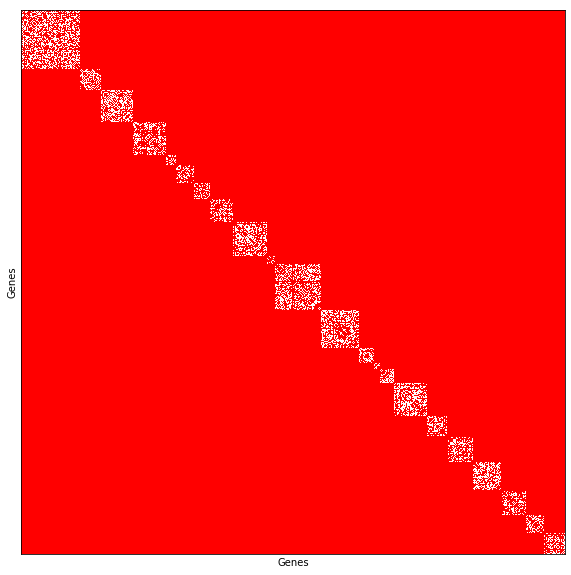

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(
    gene_corrs_df.loc[genes_order, genes_order].values, vmin=-0.05, vmax=0.05, cmap=cmap
)
ax.set_xlabel("Genes")
ax.set_ylabel("Genes")
ax.set_xticks([])
ax.set_yticks([])

# Testing

In [47]:
# COL4A1 and COL4A2
gene1 = "ENSG00000187498"
gene2 = "ENSG00000134871"

gene_corrs_df.loc[gene1, gene2]

0.018981302

In [48]:
_genes_files = all_gene_corr_files_df[all_gene_corr_files_df["chromosome"] == 13][
    "corr_file"
].tolist()
assert len(_genes_files) == 49

In [49]:
_gene_values = []
for f in _genes_files:
    gene1_gene2_corr = pd.read_pickle(f).loc[gene1, gene2]
    _gene_values.append(gene1_gene2_corr)

In [50]:
_gene_values = np.array(_gene_values)
assert _gene_values.shape[0] == 49

In [51]:
display(_gene_values.mean())
assert gene_corrs_df.loc[gene1, gene2] == _gene_values.mean()

0.018981302

# Save

## With ensemble ids

In [52]:
output_file = conf.PHENOMEXCAN["LD_BLOCKS"][EQTL_MODEL]["GENE_IDS_CORR_AVG"]
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_multiplier_genes-pred_expression_corr_avg.pkl')

In [53]:
gene_corrs_df.to_pickle(output_file)

## With gene symbols

In [54]:
output_file = conf.PHENOMEXCAN["LD_BLOCKS"][EQTL_MODEL]["GENE_NAMES_CORR_AVG"]
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/en_multiplier_genes-pred_expression_corr_avg-gene_names.pkl')

In [55]:
gene_corrs_gene_names_df = gene_corrs_df.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [56]:
assert gene_corrs_gene_names_df.index.is_unique

In [57]:
assert gene_corrs_gene_names_df.columns.is_unique

In [58]:
gene_corrs_gene_names_df.shape

(6452, 6452)

In [59]:
gene_corrs_gene_names_df.head()

id,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
id,,,,,,,,,,,,,,,,,,,,,
GAS6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
MMP14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000186,0.0,0.0,0.0,0.0,0.0
DSP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
MARCKSL1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
SPARC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [60]:
gene_corrs_gene_names_df.to_pickle(output_file)